In [2]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize

In [3]:
indir_track_cascade_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/track_mu_Burnsample_RD_Full_db.csv"
indir_energy_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/energy_Burnsample_RD_Full_db.csv"
indir_zenith_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/zenith_Burnsample_RD_Full_db.csv"
indir_azimuth_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/azimuth_Burnsample_RD_Full_db.csv"
indir_multiclass_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/pid_Burnsample_RD_Full_db.csv"

indir_track_cascade_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/dynedge_track_mu_Track_cascade_MP_data_SplitInIcePulses_on_equal_track_cascade_neutrinos_test/results.csv"
indir_energy_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/Peter_Morten_energy_1_mill_even_track_cascade_attempt_2_test_set/results.csv"
indir_zenith_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/MP_data_zenith_1_mill_even_track_cascade_attempt2_test_set/results.csv"
indir_azimuth_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/MP_data_azimuth_test_1_mill_attempt2_test_set_equal_track_cascade/results.csv"
indir_multiclass_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/dynedge_pid_classification3_test/results.csv"

In [4]:
track_cascade_RD = pd.read_csv(indir_track_cascade_RD).sort_values('event_no').reset_index(drop = True)
energy_RD = pd.read_csv(indir_energy_RD).sort_values('event_no').reset_index(drop = True)
zenith_RD = pd.read_csv(indir_zenith_RD).sort_values('event_no').reset_index(drop = True)
azimuth_RD = pd.read_csv(indir_azimuth_RD).sort_values('event_no').reset_index(drop = True)
multiclass_RD = pd.read_csv(indir_multiclass_RD).sort_values('event_no').reset_index(drop = True)

track_cascade_MC = pd.read_csv(indir_track_cascade_MC).sort_values('event_no').reset_index(drop = True)
energy_MC = pd.read_csv(indir_energy_MC).sort_values('event_no').reset_index(drop = True)
zenith_MC = pd.read_csv(indir_zenith_MC).sort_values('event_no').reset_index(drop = True)
azimuth_MC = pd.read_csv(indir_azimuth_MC).sort_values('event_no').reset_index(drop = True)
multiclass_MC = pd.read_csv(indir_multiclass_MC).sort_values('event_no').reset_index(drop = True)

[ 1.69090118 17.63873833  0.03073277]
True


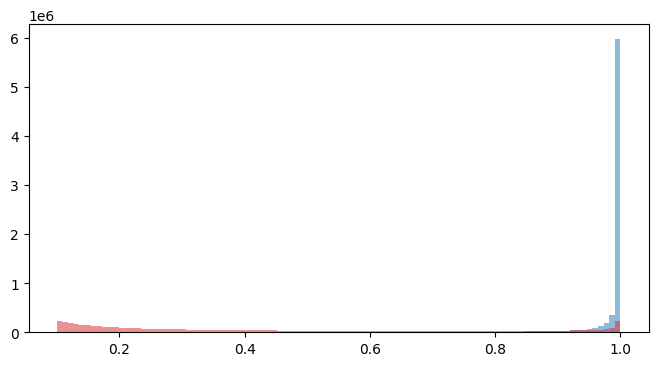

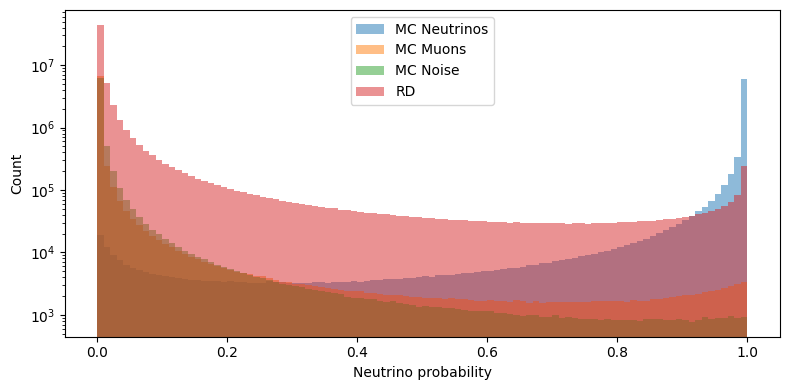

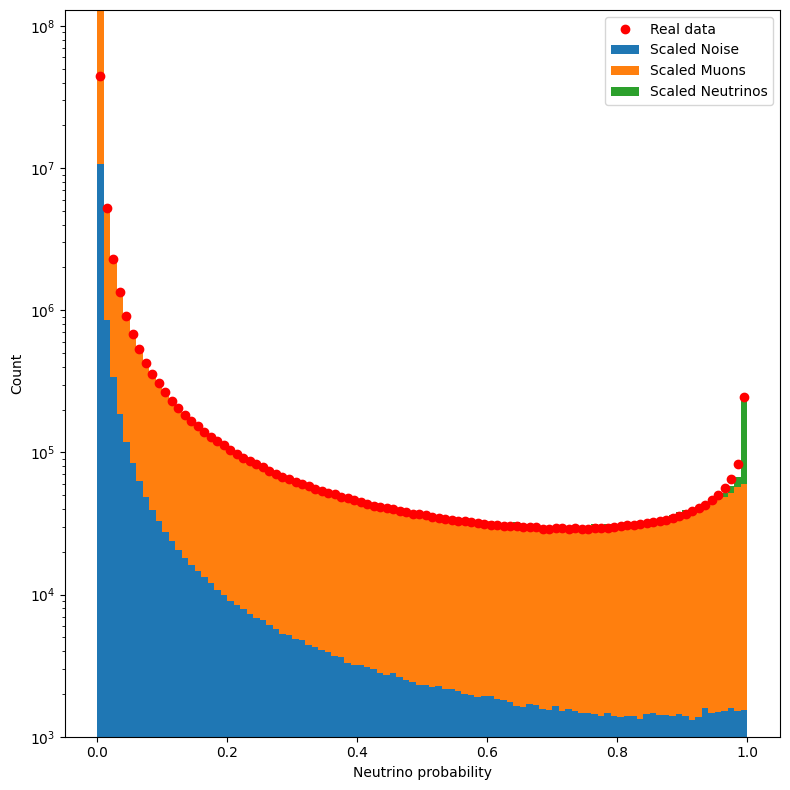

In [5]:
bins_to_use = np.linspace(0,1,101)
bins_to_fit = np.linspace(0.1,1,101)

fig,axs =  plt.subplots(figsize=(8, 4))
counts_neutrino_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos')
counts_muon_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons')
counts_noise_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise')
counts_RD_fit, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred'],bins=bins_to_fit,density=False,alpha=0.5,label='RD')


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

counts_neutrino, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos')
counts_muon, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons')
counts_noise, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise')
counts_RD, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred'],bins=bins_to_use,density=False,alpha=0.5,label='RD')

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()


def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        sum+= (counts_RD_fit[i] - N_scalers[0]*counts_noise_fit[i] - N_scalers[1]*counts_muon_fit[i] - N_scalers[2]*counts_neutrino_fit[i])**2/counts_RD_fit[i]
    return sum

N_0 = [50000,50000,50000]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

counts_noise_plot = counts_noise*res.x[0]#
counts_muon_plot = counts_muon*res.x[1]##
counts_neutrino_plot = counts_neutrino*res.x[2]#*#


bin_width = bins_to_use[1]-bins_to_use[0]

fig, axs = plt.subplots(figsize=(8, 8))


axs.bar(bins_middle,counts_noise_plot,width=bin_width,label='Scaled Noise')
axs.bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='Scaled Muons')
axs.bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='Scaled Neutrinos')


axs.plot(bins_middle,counts_RD,'o',label='Real data',color='red')
axs.set_xlabel('Neutrino probability')
axs.set_ylim(bottom=1000)
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

In [6]:
def to_logit(p):
    eps = 0.0000001
    try:
        if np.isnan(p):
            return
        p = p*(1-2*eps)+eps
        logit = np.log(p/(1-p))
    except ZeroDivisionError as e:
        print(e)
    return logit

safe_load_place_MC = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/event_selections/Neutrino_prob_logit_MC.csv"
load_logit_MC = True
if load_logit_MC:
    input = pd.read_csv(safe_load_place_MC)
    multiclass_MC['pid_neutrino_pred_logit'] = input['pid_neutrino_pred_logit']
else:
    multiclass_MC['pid_neutrino_pred_logit'] = pd.Series(multiclass_MC['pid_neutrino_pred']).apply(to_logit)
    multiclass_MC['pid_neutrino_pred_logit'].to_csv(safe_load_place_MC)




safe_load_place_RD = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/inference/event_selections/Neutrino_prob_logit_RD.csv"
load_logit_RD = True
if load_logit_RD:
    input = pd.read_csv(safe_load_place_RD)
    multiclass_RD['pid_neutrino_pred_logit'] = input['pid_neutrino_pred']
else:
    multiclass_RD['pid_neutrino_pred_logit'] = pd.Series(multiclass_RD['pid_neutrino_pred']).apply(to_logit)



[8.31610442 3.61945589 0.02618362]
True


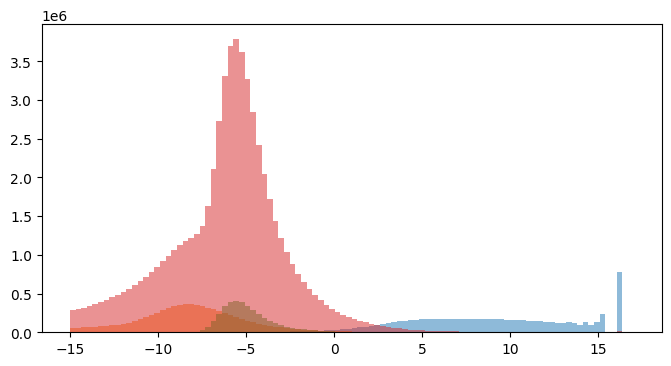

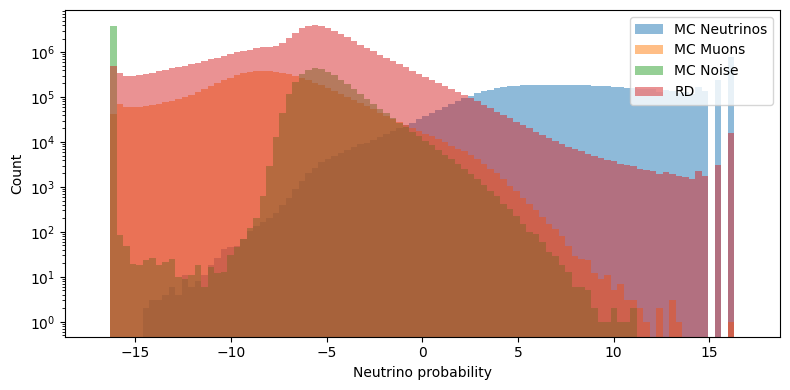

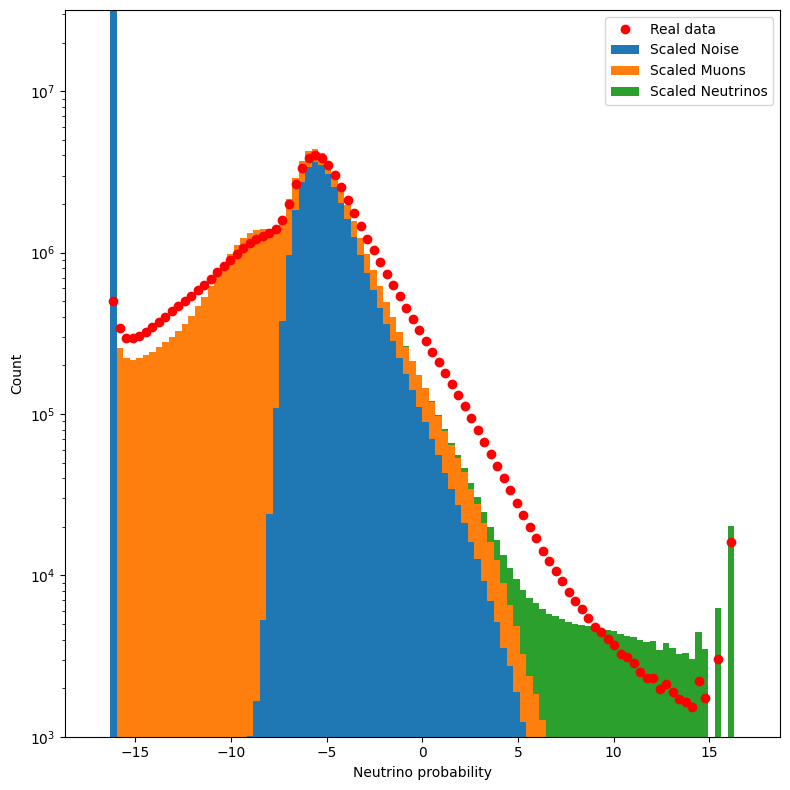

In [7]:
bins_to_use = np.linspace(-17,17,101)
bins_to_fit = np.linspace(-15,17,101)

fig,axs =  plt.subplots(figsize=(8, 4))
counts_neutrino_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Neutrinos')
counts_muon_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Muons')
counts_noise_fit, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_fit,density=False,alpha=0.5,label='MC Noise')
counts_RD_fit, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred_logit'],bins=bins_to_fit,density=False,alpha=0.5,label='RD')


fig, axs = plt.subplots(figsize=(8, 4))


bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

counts_neutrino, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-12,12,-14,14,-16,16))],bins=bins_to_use,density=False,alpha=0.5,label='MC Neutrinos')
counts_muon, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-13,13))],bins=bins_to_use,density=False,alpha=0.5,label='MC Muons')
counts_noise, _,_ = axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['pid'].isin((-1,1))],bins=bins_to_use,density=False,alpha=0.5,label='MC Noise')
counts_RD, _,_ = axs.hist(multiclass_RD['pid_neutrino_pred_logit'],bins=bins_to_use,density=False,alpha=0.5,label='RD')

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Neutrino probability')
axs.legend()

fig.tight_layout()


def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        if counts_RD_fit[i] != 0:
            sum+= (counts_RD_fit[i] - N_scalers[0]*counts_noise_fit[i] - N_scalers[1]*counts_muon_fit[i] - N_scalers[2]*counts_neutrino_fit[i])**2/counts_RD_fit[i]
    return sum

N_0 = [ 1.69090118, 17.63873833,  0.03073277]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None),(0, None), (0, None)))
print(res.x)
print(res.success)

counts_noise_plot = counts_noise*res.x[0]#
counts_muon_plot = counts_muon*res.x[1]##
counts_neutrino_plot = counts_neutrino*res.x[2]#*#



bin_width = bins_to_use[1]-bins_to_use[0]

fig, axs = plt.subplots(figsize=(8, 8))


axs.bar(bins_middle,counts_noise_plot,width=bin_width,label='Scaled Noise')
axs.bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='Scaled Muons')
axs.bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='Scaled Neutrinos')


axs.plot(bins_middle,counts_RD,'o',label='Real data',color='red')
axs.set_xlabel('Neutrino probability')
axs.set_ylim(bottom=1000)
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

In [8]:
Neutrino_cut = 16
pure_neutrino_selection_RD = multiclass_RD['event_no'][multiclass_RD['pid_neutrino_pred_logit'] > Neutrino_cut]
pure_neutrino_selection_MC = multiclass_MC['event_no'][multiclass_MC['pid_neutrino_pred_logit'] > Neutrino_cut]

In [9]:
print('this many pure neutrinos RD',len(pure_neutrino_selection_RD))
print('this many pure neutrinos MC',len(pure_neutrino_selection_MC))
track_event_no = track_cascade_MC['event_no'][track_cascade_MC['track_mu']==1]
cascade_event_no = track_cascade_MC['event_no'][track_cascade_MC['track_mu']==0]

pure_neutrino_track_selection = track_event_no[track_event_no.isin((pure_neutrino_selection_MC))].reset_index(drop=True)

pure_neutrino_cascade_selection = cascade_event_no[cascade_event_no.isin((pure_neutrino_selection_MC))].reset_index(drop=True)
#print(track_event_no)
#print(cascade_event_no)

this many pure neutrinos RD 16145
this many pure neutrinos MC 773681


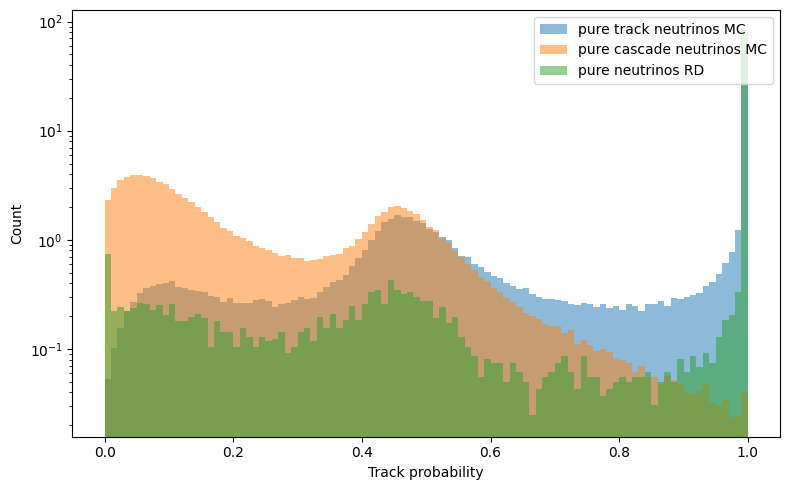

In [10]:
fig, axs = plt.subplots(figsize=(8, 5))

bins_to_use = np.linspace(0,1,101)
axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)],density=True,bins=bins_to_use,label='pure track neutrinos MC',alpha=0.5)
axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection) ],density=True,bins=bins_to_use,label='pure cascade neutrinos MC',alpha=0.5)
axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)],density=True,bins=bins_to_use,label='pure neutrinos RD',alpha=0.5)

axs.set_xlabel('Track probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

[0.01185297 0.00402774]
True


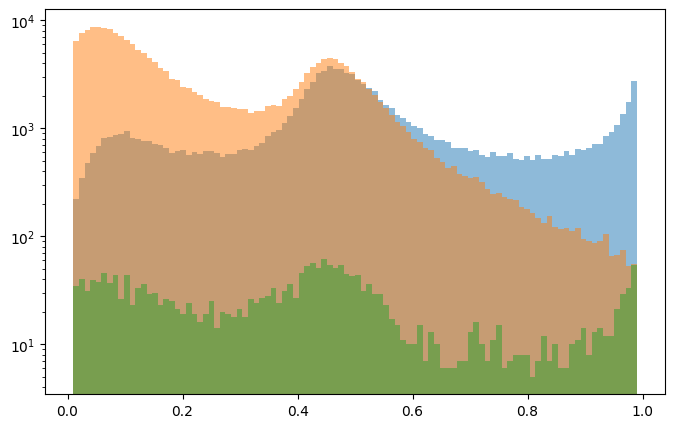

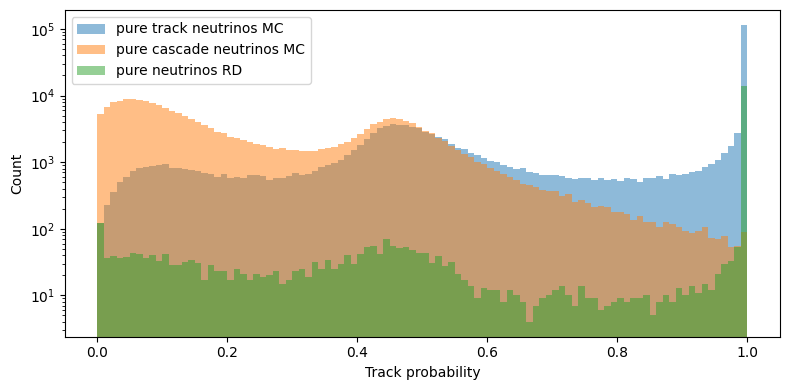

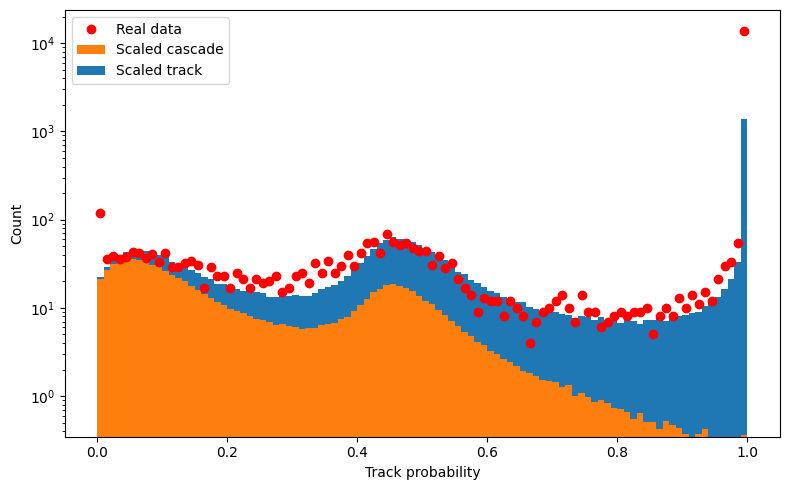

In [11]:
bins_to_use = np.linspace(0,1,101)
bins_to_fit = np.linspace(0.01,0.99,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2

fig, axs = plt.subplots(figsize=(8, 5))

counts_track_fit, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)],density=False,bins=bins_to_fit,label='pure track neutrinos MC',alpha=0.5)
counts_cascade_fit, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection)],density=False,bins=bins_to_fit,label='pure cascade neutrinos MC',alpha=0.5)
counts_RD_fit, _,_ = axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins_to_fit,label='pure neutrinos RD',alpha=0.5)

axs.set_yscale('log')

fig, axs = plt.subplots(figsize=(8, 4))


counts_track, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_track_selection)],density=False,bins=bins_to_use,label='pure track neutrinos MC',alpha=0.5)
counts_cascade, _,_ = axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_neutrino_cascade_selection)],density=False,bins=bins_to_use,label='pure cascade neutrinos MC',alpha=0.5)
counts_RD_multiclass, _,_ = axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_neutrino_selection_RD)],density=False,bins=bins_to_use,label='pure neutrinos RD',alpha=0.5)


axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Track probability')
axs.legend()

fig.tight_layout()


def chi_square(N_scalers):
    sum = 0
    for i in range(len(bins_to_fit)-1):
        sum+= (counts_RD_fit[i] - N_scalers[0]*counts_track_fit[i] - N_scalers[1]*counts_cascade_fit[i])**2/counts_RD_fit[i]
    return sum

N_0 = [50,50]
res = optimize.minimize(chi_square,N_0,bounds = ((0, None), (0, None)))
print(res.x)
print(res.success)

counts_track_plot = counts_track*res.x[0]#
counts_cascade_plot = counts_cascade*res.x[1]##

bin_width = bins_to_use[1]-bins_to_use[0]

fig, axs = plt.subplots(figsize=(8, 5))


axs.bar(bins_middle,counts_cascade_plot,width=bin_width,label='Scaled cascade',color='C1')
axs.bar(bins_middle,counts_track_plot,width=bin_width,bottom=counts_cascade_plot,label='Scaled track',color='C0')


axs.plot(bins_middle,counts_RD_multiclass,'o',label='Real data',color='red')
axs.set_xlabel('Track probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()


In [12]:
track_cut = 0.9
pure_track_event_no_MC = track_cascade_MC['event_no'][track_cascade_MC['track_mu_pred']>track_cut]
pure_track_event_no_RD = track_cascade_RD['event_no'][track_cascade_RD['track_mu_pred']>track_cut]

pure_cascade_event_no_MC = track_cascade_MC['event_no'][track_cascade_MC['track_mu_pred']<track_cut]
pure_cascade_event_no_RD = track_cascade_RD['event_no'][track_cascade_RD['track_mu_pred']<track_cut]


pure_track_selection_MC = pure_track_event_no_MC[pure_track_event_no_MC.isin(pure_neutrino_selection_MC)]
pure_track_selection_RD = pure_track_event_no_RD[pure_track_event_no_RD.isin(pure_neutrino_selection_RD)]


pure_cascade_selection_MC = pure_cascade_event_no_MC[pure_cascade_event_no_MC.isin(pure_neutrino_selection_MC)]
pure_cascade_selection_RD = pure_cascade_event_no_RD[pure_cascade_event_no_RD.isin(pure_neutrino_selection_RD)]

print(len(pure_track_selection_MC))
print(len(pure_track_selection_RD))
print(len(pure_cascade_selection_MC))
print(len(pure_cascade_selection_RD))

126776
13871
321423
2274


In [13]:
# print(len(pure_track_selection_MC))
# print(len(pure_track_selection_RD))

# fig, axs = plt.subplots(figsize=(8, 8))

# axs.hist(track_cascade_MC['track_mu_pred'][track_cascade_MC['event_no'].isin(pure_track_selection_MC)])
# axs.hist(track_cascade_RD['track_mu_pred'][track_cascade_RD['event_no'].isin(pure_track_selection_RD)])

# axs.set_xlabel('Neutrino probability')
# #axs.set_ylim(bottom=1000)
# axs.set_ylabel('Count')
# axs.set_yscale('log')
# axs.legend(loc='upper left')

# fig.tight_layout()

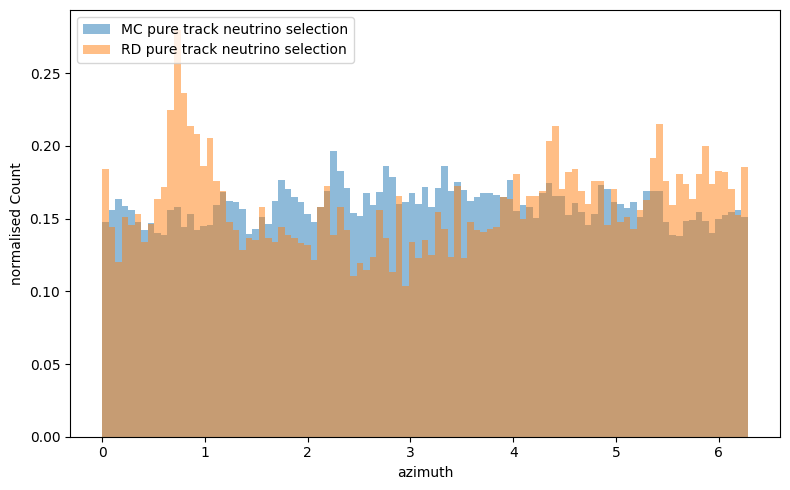

In [14]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection',bins=bins,alpha=0.5)
axs.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_track_selection_RD)],density=True,label='RD pure track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

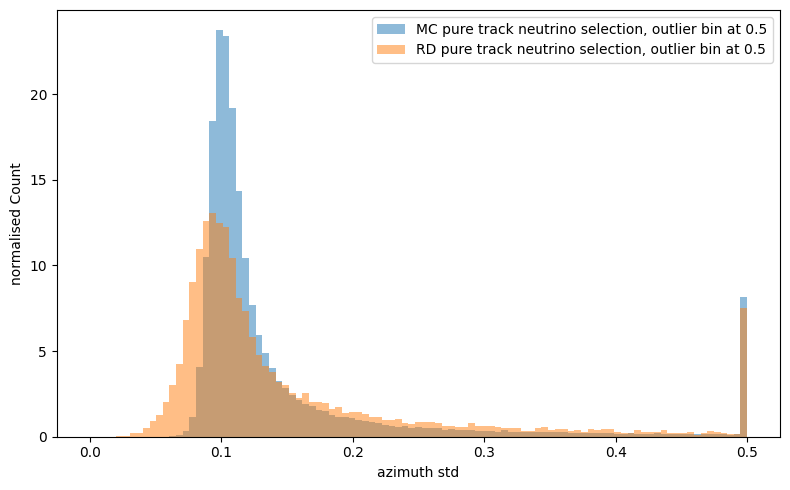

In [15]:
bins=np.linspace(0,0.5,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5),density=True,label='MC pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
axs.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=True,label='RD pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

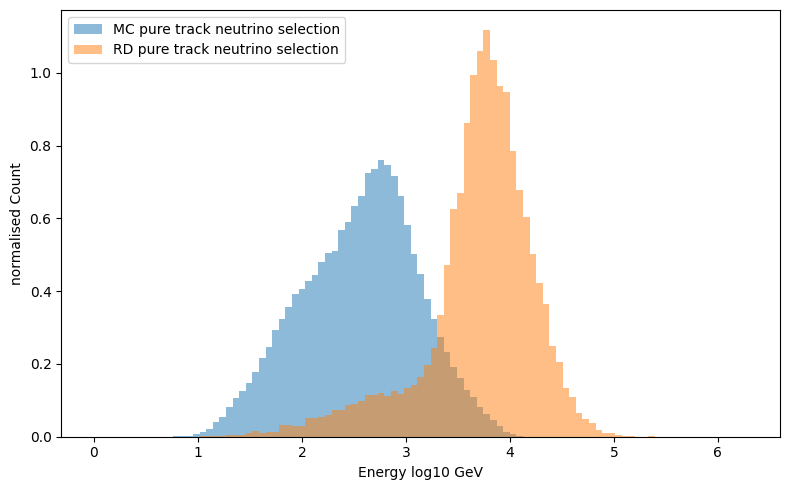

In [16]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_track_selection_MC)]),density=True,label='MC pure track neutrino selection',bins=bins,alpha=0.5)
axs.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_track_selection_RD)]),density=True,label='RD pure track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Energy log10 GeV')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

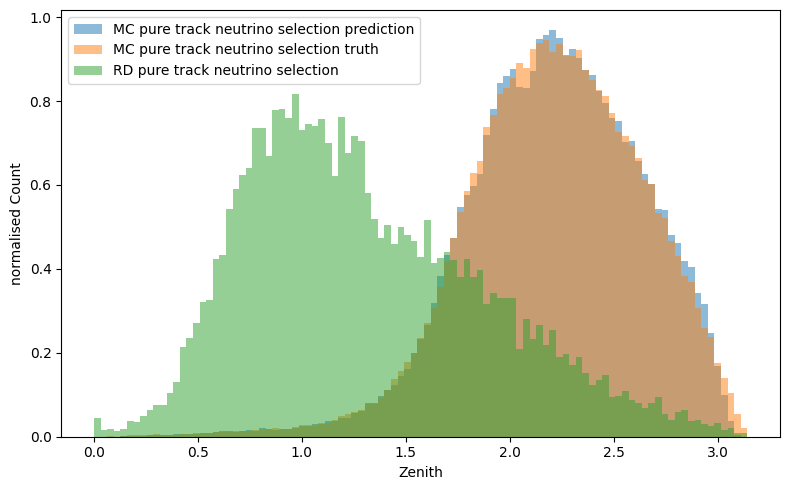

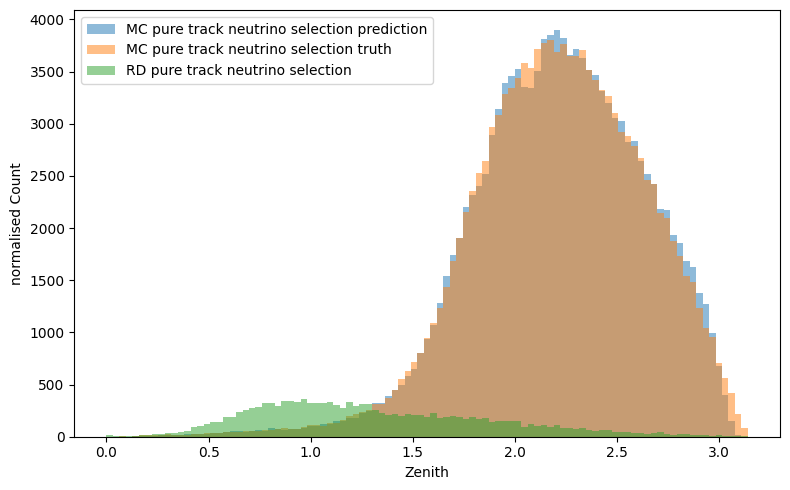

In [17]:
bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection prediction',bins=bins,alpha=0.5)
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection truth',bins=bins,alpha=0.5)
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_track_selection_RD)],density=True,label='RD pure track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()


bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=False,label='MC pure track neutrino selection prediction',bins=bins,alpha=0.5)
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=False,label='MC pure track neutrino selection truth',bins=bins,alpha=0.5)
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_track_selection_RD)],density=False,label='RD pure track neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

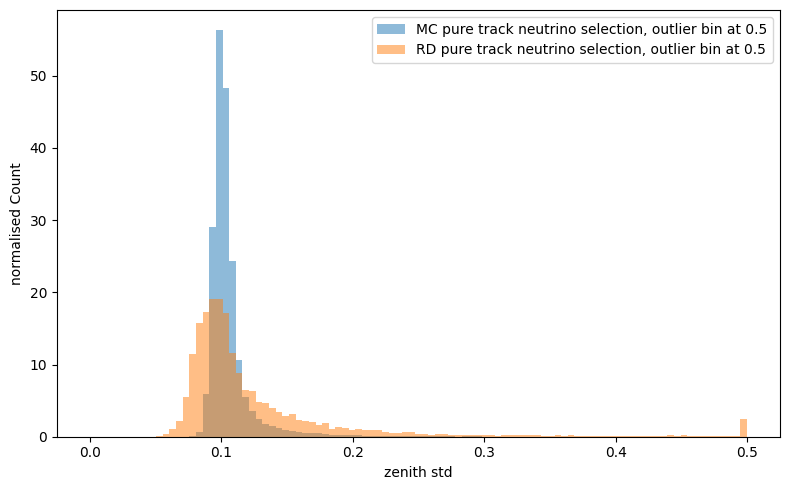

In [18]:
bins=np.linspace(0,0.5,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5),density=True,label='MC pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
axs.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=True,label='RD pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)

axs.set_xlabel('zenith std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

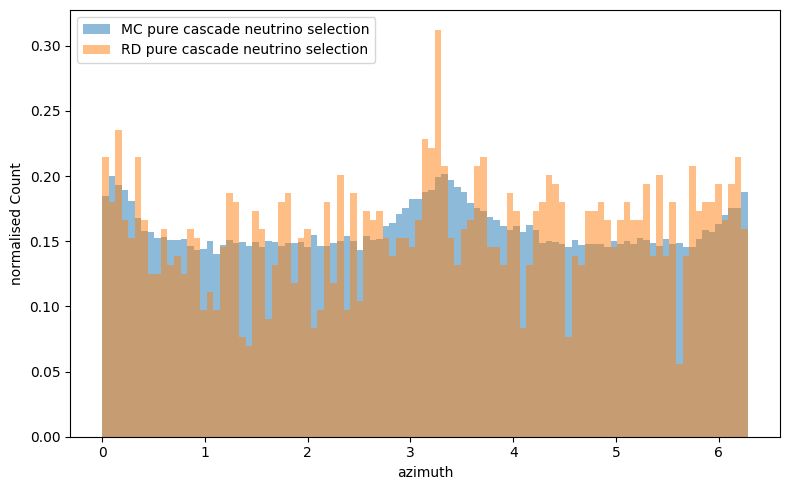

In [19]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection',bins=bins,alpha=0.5)
axs.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)],density=True,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

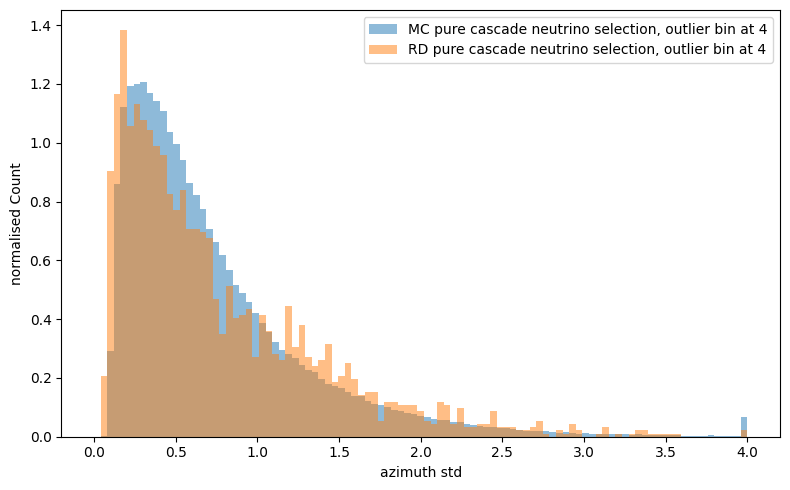

In [20]:
bins=np.linspace(0,4,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)]),0,4),density=True,label='MC pure cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5)
axs.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)]),0,4),density=True,label='RD pure cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5)

axs.set_xlabel('azimuth std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

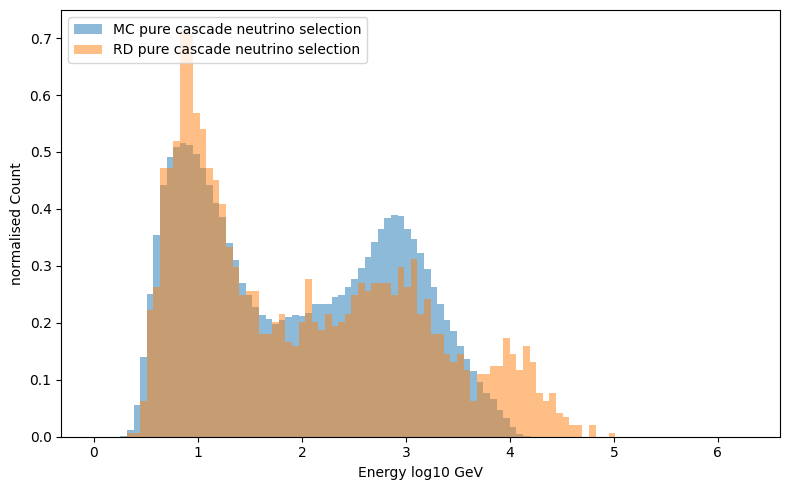

In [21]:
bins=np.linspace(0,np.pi*2,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_cascade_selection_MC)]),density=True,label='MC pure cascade neutrino selection',bins=bins,alpha=0.5)
axs.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_cascade_selection_RD)]),density=True,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Energy log10 GeV')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

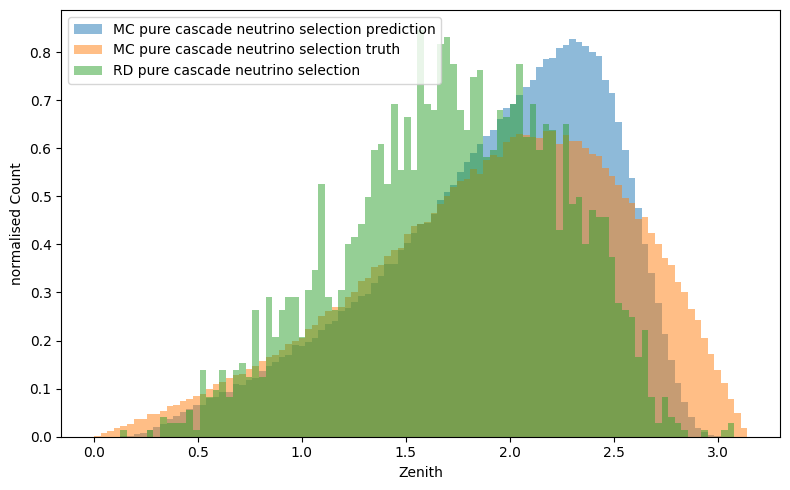

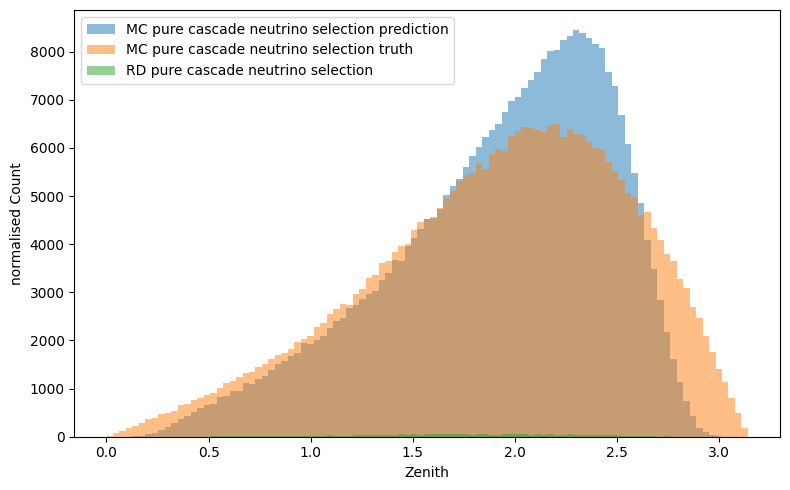

In [22]:
bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection prediction',bins=bins,alpha=0.5)
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection truth',bins=bins,alpha=0.5)
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)],density=True,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()


bins=np.linspace(0,np.pi,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=False,label='MC pure cascade neutrino selection prediction',bins=bins,alpha=0.5)
axs.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=False,label='MC pure cascade neutrino selection truth',bins=bins,alpha=0.5)
axs.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)],density=False,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)

axs.set_xlabel('Zenith')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

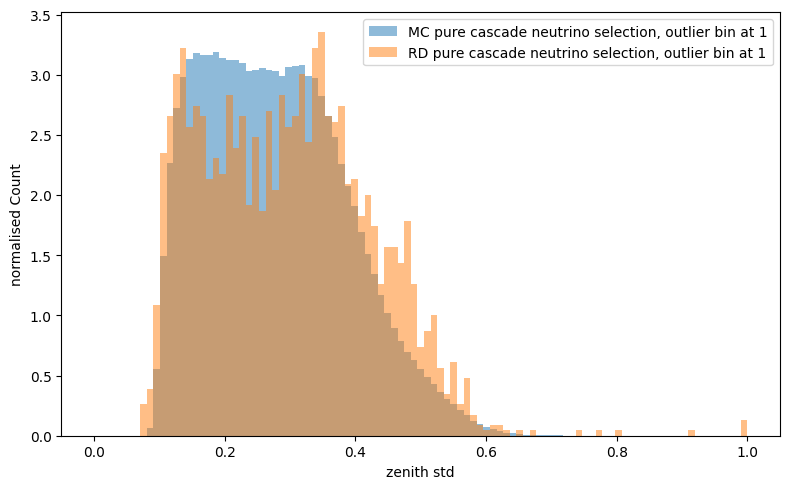

In [23]:
bins=np.linspace(0,1,100)
fig, axs = plt.subplots(figsize=(8, 5))

axs.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)]),0,1),density=True,label='MC pure cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5)
axs.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)]),0,1),density=True,label='RD pure cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5)

axs.set_xlabel('zenith std')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('normalised Count')
#axs.set_yscale('log')
axs.legend(loc='upper right')

fig.tight_layout()

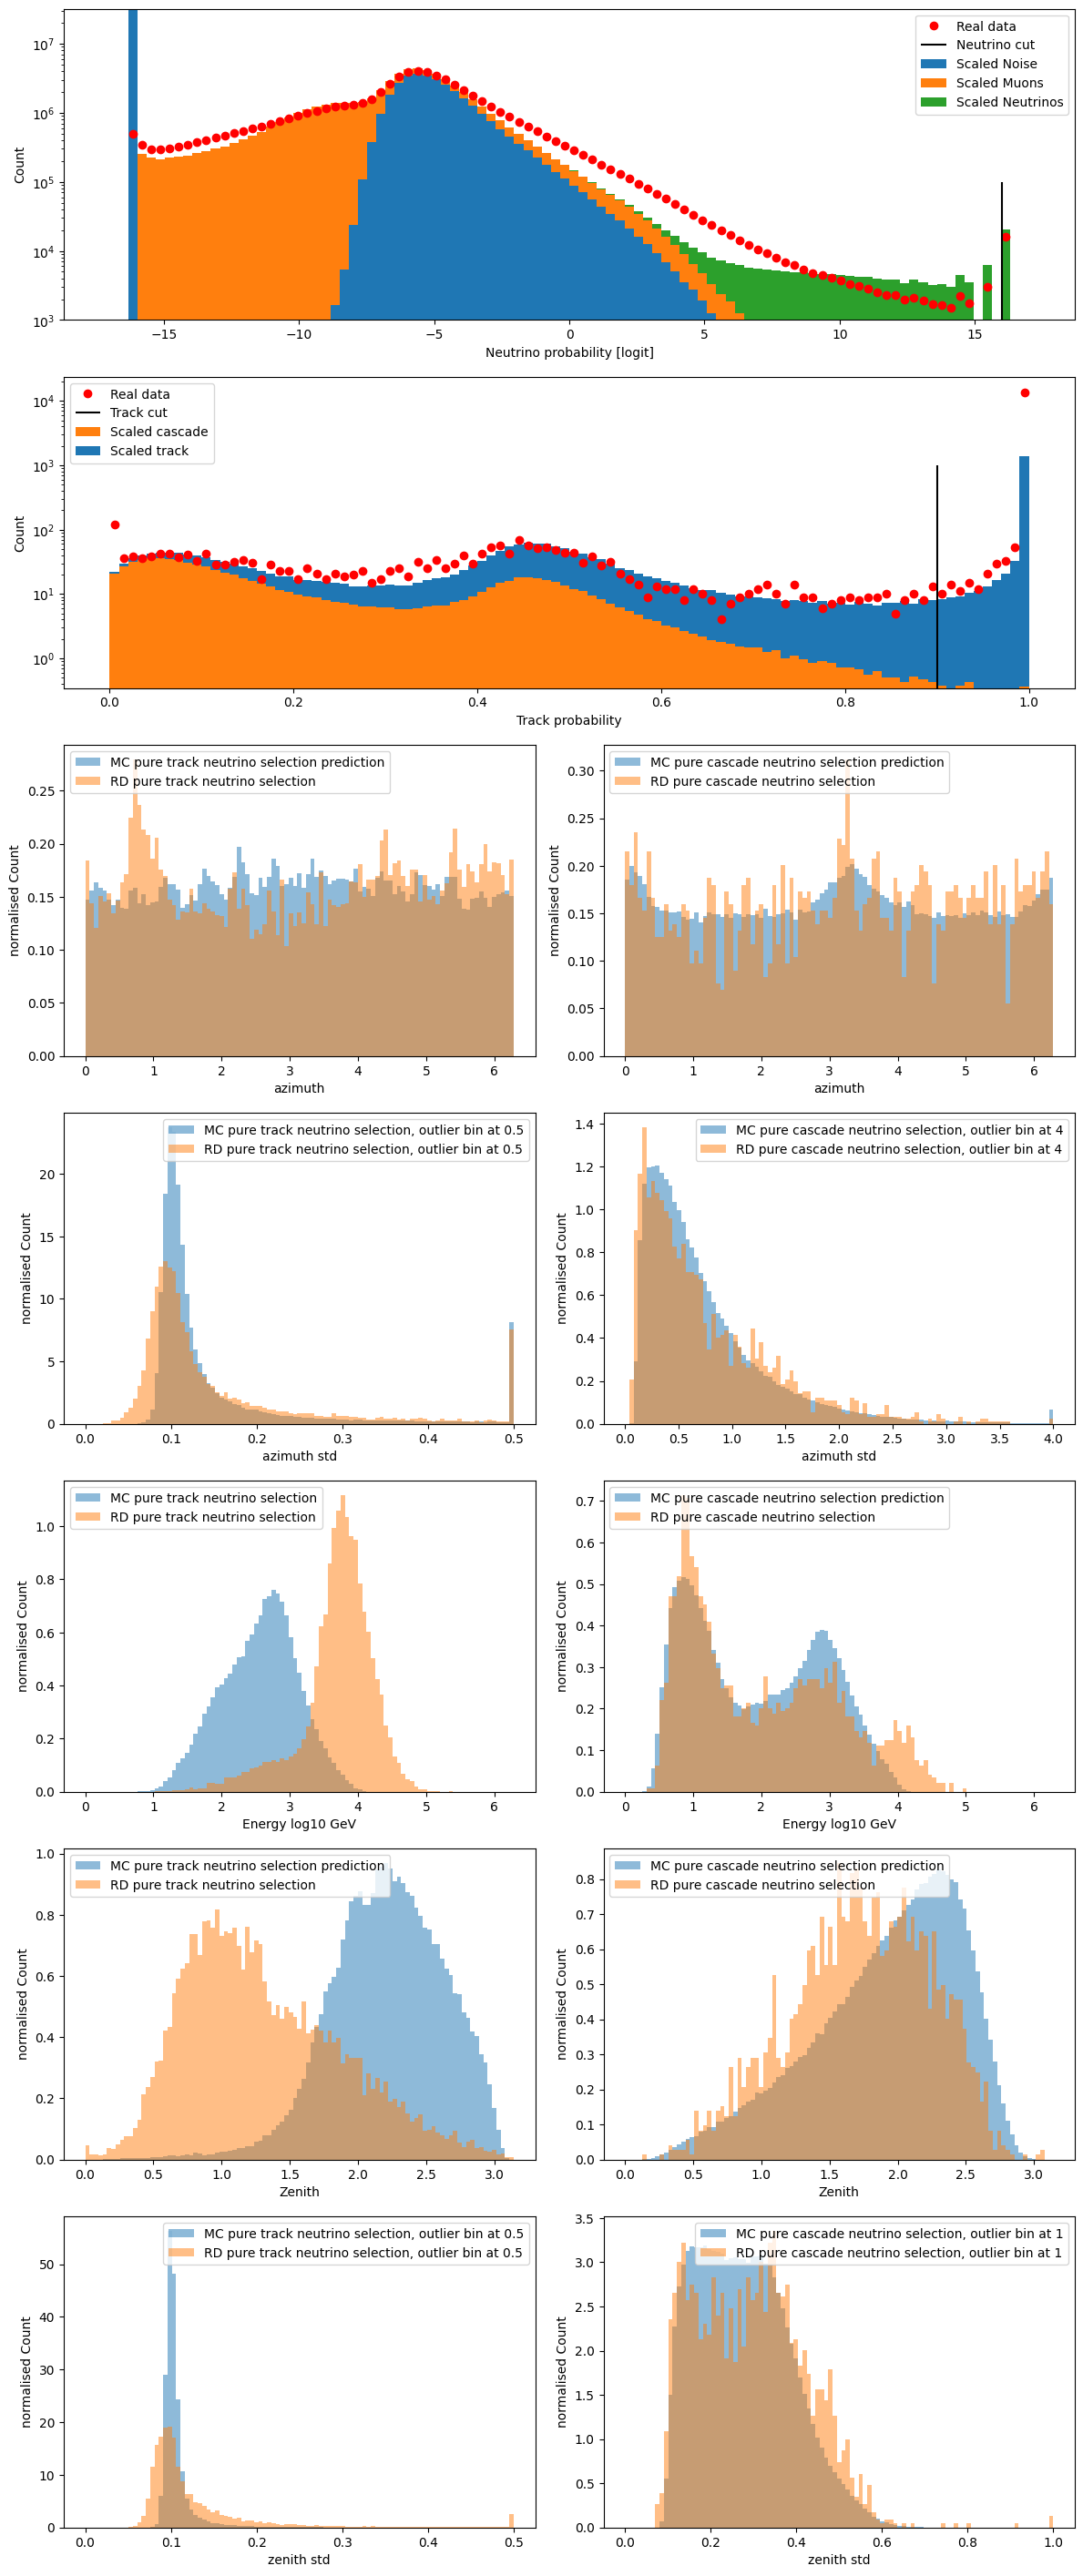

In [24]:
with_MC_truth = False


bins_to_use = np.linspace(-17,17,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]

fig = plt.figure(figsize=(12,32))
ax1 = plt.subplot2grid(shape=(8,2), loc=(0,0), colspan=2, fig=fig)
ax1.bar(bins_middle,counts_noise_plot,width=bin_width,label='Scaled Noise')
ax1.bar(bins_middle,counts_muon_plot,width=bin_width,bottom=counts_noise_plot,label='Scaled Muons')
ax1.bar(bins_middle,counts_neutrino_plot,width=bin_width,bottom=counts_noise_plot+counts_muon_plot,label='Scaled Neutrinos')
ax1.plot(bins_middle,counts_RD,'o',label='Real data',color='red')
ax1.vlines(Neutrino_cut,0,10**5,color='black',label='Neutrino cut')
ax1.set_xlabel('Neutrino probability [logit]')
ax1.set_ylim(bottom=1000)
ax1.set_ylabel('Count')
ax1.set_yscale('log')
ax1.legend(loc='upper right')


bins_to_use = np.linspace(0,1,101)
bins_middle = (bins_to_use[1:]+bins_to_use[:-1])/2
bin_width = bins_to_use[1]-bins_to_use[0]
ax2 = plt.subplot2grid((8,2), (1,0), colspan=2)
ax2.bar(bins_middle,counts_cascade_plot,width=bin_width,label='Scaled cascade',color='C1')
ax2.bar(bins_middle,counts_track_plot,width=bin_width,bottom=counts_cascade_plot,label='Scaled track',color='C0')
ax2.plot(bins_middle,counts_RD_multiclass,'o',label='Real data',color='red')
ax2.vlines(track_cut,0,10**3,color='black',label='Track cut')
ax2.set_xlabel('Track probability')
ax2.set_ylabel('Count')
ax2.set_yscale('log')
ax2.legend(loc='upper left')

bins=np.linspace(0,np.pi*2,100)
ax3 = plt.subplot2grid((8,2), (2,0), colspan=1)
ax3.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection prediction',bins=bins,alpha=0.5)
ax3.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_track_selection_RD)],density=True,label='RD pure track neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax3.hist(azimuth_MC['azimuth'][azimuth_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection truch',bins=bins,alpha=0.5)
ax3.set_xlabel('azimuth')
ax3.set_ylabel('normalised Count')
ax3.legend(loc='upper left')

ax4 = plt.subplot2grid((8,2), (2,1), colspan=1)
bins=np.linspace(0,np.pi*2,100)
ax4.hist(azimuth_MC['azimuth_pred'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection prediction',bins=bins,alpha=0.5)
ax4.hist(azimuth_RD['azimuth_pred'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)],density=True,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax4.hist(azimuth_MC['azimuth'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection truth',bins=bins,alpha=0.5)
ax4.set_xlabel('azimuth')
ax4.set_ylabel('normalised Count')
ax4.legend(loc='upper left')

ax5 = plt.subplot2grid((8,2), (3,0), colspan=1)
bins=np.linspace(0,0.5,100)
ax5.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5),density=True,label='MC pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
ax5.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=True,label='RD pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
ax5.set_xlabel('azimuth std')
ax5.set_ylabel('normalised Count')
ax5.legend(loc='upper right')


ax6 = plt.subplot2grid((8,2), (3,1), colspan=1)
bins=np.linspace(0,4,100)
ax6.hist(np.clip(1/np.sqrt(azimuth_MC['azimuth_kappa'][azimuth_MC['event_no'].isin(pure_cascade_selection_MC)]),0,4),density=True,label='MC pure cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5)
ax6.hist(np.clip(1/np.sqrt(azimuth_RD['azimuth_kappa'][azimuth_RD['event_no'].isin(pure_cascade_selection_RD)]),0,4),density=True,label='RD pure cascade neutrino selection, outlier bin at 4',bins=bins,alpha=0.5)
ax6.set_xlabel('azimuth std')
ax6.set_ylabel('normalised Count')
ax6.legend(loc='upper right')

ax7 = plt.subplot2grid((8,2), (4,0), colspan=1)
bins=np.linspace(0,np.pi*2,100)
ax7.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_track_selection_MC)]),density=True,label='MC pure track neutrino selection',bins=bins,alpha=0.5)
ax7.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_track_selection_RD)]),density=True,label='RD pure track neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax7.hist(np.log10(energy_MC['energy'][energy_MC['event_no'].isin(pure_track_selection_MC)]),density=True,label='MC pure track neutrino selection',bins=bins,alpha=0.5)

ax7.set_xlabel('Energy log10 GeV')
ax7.set_ylabel('normalised Count')
ax7.legend(loc='upper left')


ax8 = plt.subplot2grid((8,2), (4,1), colspan=1)
bins=np.linspace(0,np.pi*2,100)
ax8.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_cascade_selection_MC)]),density=True,label='MC pure cascade neutrino selection prediction',bins=bins,alpha=0.5)
ax8.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_cascade_selection_RD)]),density=True,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax8.hist(np.log10(energy_MC['energy'][energy_MC['event_no'].isin(pure_cascade_selection_MC)]),density=True,label='MC pure cascade neutrino selection truth',bins=bins,alpha=0.5)
ax8.set_xlabel('Energy log10 GeV')
ax8.set_ylabel('normalised Count')
ax8.legend(loc='upper left')



ax9 = plt.subplot2grid((8,2), (5,0), colspan=1)
bins=np.linspace(0,np.pi,100)
ax9.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection prediction',bins=bins,alpha=0.5)
ax9.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_track_selection_RD)],density=True,label='RD pure track neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax9.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_track_selection_MC)],density=True,label='MC pure track neutrino selection truth',bins=bins,alpha=0.5)
ax9.set_xlabel('Zenith')
ax9.set_ylabel('normalised Count')
ax9.legend(loc='upper left')



ax10 = plt.subplot2grid((8,2), (5,1), colspan=1)
bins=np.linspace(0,np.pi,100)
ax10.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection prediction',bins=bins,alpha=0.5)
ax10.hist(zenith_RD['zenith_pred'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)],density=True,label='RD pure cascade neutrino selection',bins=bins,alpha=0.5)
if with_MC_truth:
    ax10.hist(zenith_MC['zenith'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)],density=True,label='MC pure cascade neutrino selection truth',bins=bins,alpha=0.5)
ax10.set_xlabel('Zenith')
ax10.set_ylabel('normalised Count')
ax10.legend(loc='upper left')


ax11 = plt.subplot2grid((8,2), (6,0), colspan=1)
bins=np.linspace(0,0.5,100)
ax11.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_track_selection_MC)]),0,0.5),density=True,label='MC pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
ax11.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_track_selection_RD)]),0,0.5),density=True,label='RD pure track neutrino selection, outlier bin at 0.5',bins=bins,alpha=0.5)
ax11.set_xlabel('zenith std')
ax11.set_ylabel('normalised Count')
ax11.legend(loc='upper right')


ax12 = plt.subplot2grid((8,2), (6,1), colspan=1)
bins=np.linspace(0,1,100)
ax12.hist(np.clip(1/np.sqrt(zenith_MC['zenith_kappa'][zenith_MC['event_no'].isin(pure_cascade_selection_MC)]),0,1),density=True,label='MC pure cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5)
ax12.hist(np.clip(1/np.sqrt(zenith_RD['zenith_kappa'][zenith_RD['event_no'].isin(pure_cascade_selection_RD)]),0,1),density=True,label='RD pure cascade neutrino selection, outlier bin at 1',bins=bins,alpha=0.5)
ax12.set_xlabel('zenith std')
ax12.set_ylabel('normalised Count')
ax12.legend(loc='upper right')


fig.tight_layout()

In [25]:
print(track_cascade_MC.head(10))

   Unnamed: 0  track_mu_pred  track_mu  event_no
0     4109962       0.511379       1.0     320.0
1     1810779       0.437622       1.0     344.0
2     3806952       0.412146       1.0     370.0
3     3266424       0.461440       1.0     378.0
4     1569369       0.516302       1.0     381.0
5      634826       0.552189       1.0     456.0
6     3590453       0.492596       1.0     582.0
7      917985       0.457702       1.0     613.0
8     2817052       0.450149       1.0     619.0
9     1738854       0.433827       1.0     643.0


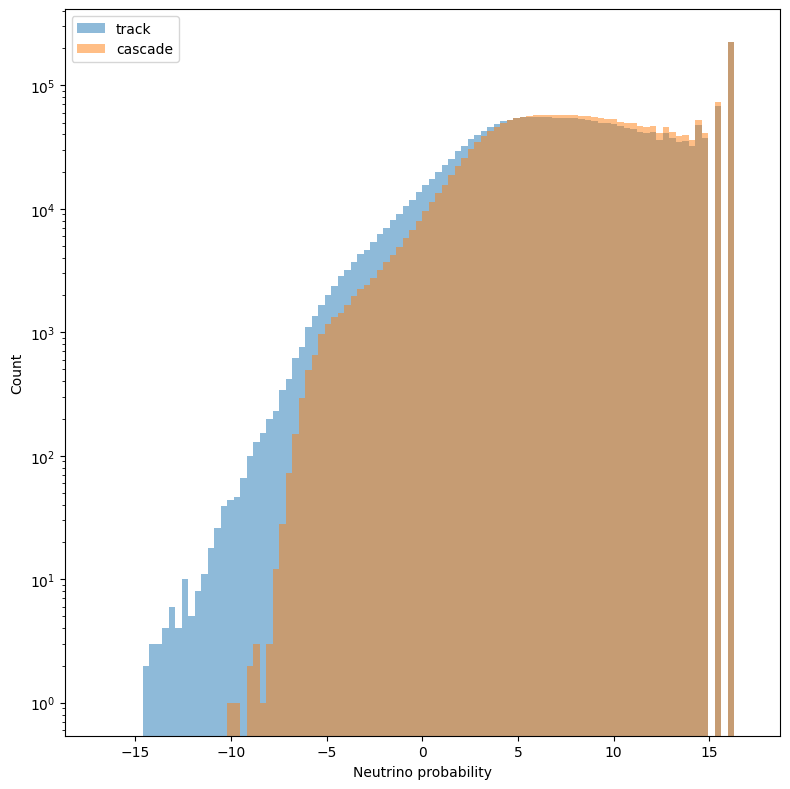

In [26]:

bins_to_use=np.linspace(-17,17,101)
fig, axs = plt.subplots(figsize=(8, 8))


axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['event_no'].isin(track_event_no)],bins=bins_to_use,alpha=0.5,label='track')
axs.hist(multiclass_MC['pid_neutrino_pred_logit'][multiclass_MC['event_no'].isin(cascade_event_no)],bins=bins_to_use,alpha=0.5,label='cascade')

axs.set_xlabel('Neutrino probability')
#axs.set_ylim(bottom=1000)
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend(loc='upper left')

fig.tight_layout()

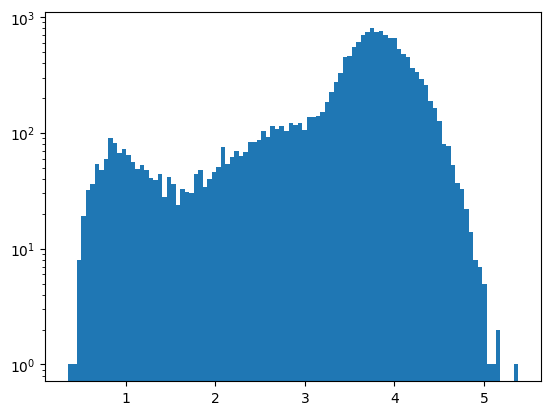

In [27]:
plt.hist(np.log10(energy_RD['energy_pred'][energy_RD['event_no'].isin(pure_neutrino_selection_RD)]),bins=100)
plt.yscale('log')

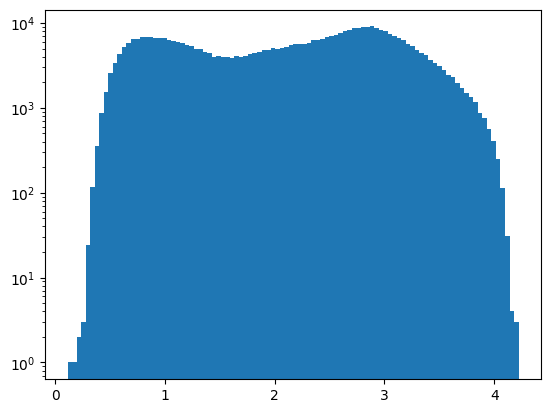

In [28]:
plt.hist(np.log10(energy_MC['energy_pred'][energy_MC['event_no'].isin(pure_neutrino_selection_MC)]),bins=100)
plt.yscale('log')

(array([4.0000e+00, 1.9000e+01, 3.3000e+01, 6.3000e+01, 1.0000e+02,
        1.7400e+02, 2.1000e+02, 2.9200e+02, 3.7500e+02, 4.3300e+02,
        4.9900e+02, 5.7100e+02, 6.5500e+02, 6.7400e+02, 7.3200e+02,
        8.0400e+02, 8.9800e+02, 9.6000e+02, 9.8000e+02, 1.0860e+03,
        1.1260e+03, 1.2270e+03, 1.2640e+03, 1.3950e+03, 1.4900e+03,
        1.5370e+03, 1.6540e+03, 1.6560e+03, 1.9150e+03, 1.8890e+03,
        1.9440e+03, 2.0610e+03, 2.2210e+03, 2.2610e+03, 2.4420e+03,
        2.5590e+03, 2.7090e+03, 2.7980e+03, 2.9080e+03, 3.0720e+03,
        3.1500e+03, 3.3920e+03, 3.5560e+03, 3.8350e+03, 3.9450e+03,
        4.1590e+03, 4.4420e+03, 4.7200e+03, 5.0060e+03, 5.2880e+03,
        5.3460e+03, 5.8950e+03, 6.3040e+03, 6.6900e+03, 6.9270e+03,
        7.4290e+03, 7.7570e+03, 7.9040e+03, 8.2390e+03, 8.7130e+03,
        9.0050e+03, 9.5180e+03, 9.7700e+03, 9.8680e+03, 1.0018e+04,
        9.9130e+03, 1.0351e+04, 1.0730e+04, 1.1063e+04, 1.1107e+04,
        1.1371e+04, 1.1176e+04, 1.1430e+04, 1.13

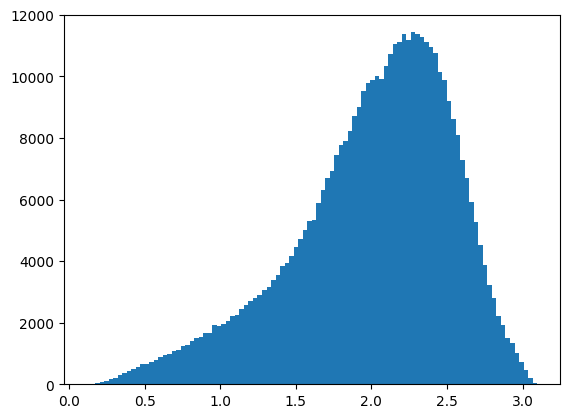

In [29]:
plt.hist(zenith_MC['zenith_pred'][zenith_MC['event_no'].isin(pure_neutrino_selection_MC)],bins=100)

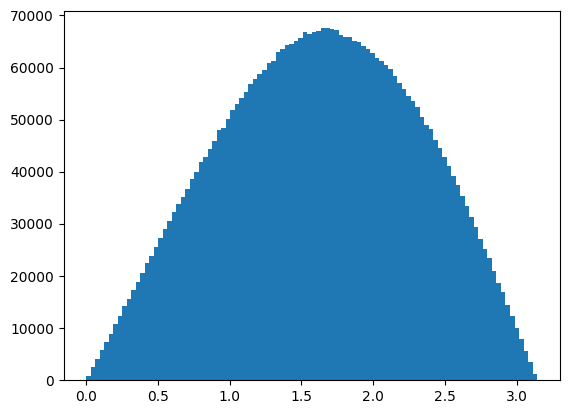

In [30]:
hist = plt.hist(zenith_MC['zenith'][~zenith_MC['event_no'].isin(pure_neutrino_selection_MC)],bins=100)

In [31]:
print(len(zenith_MC['zenith'][~zenith_MC['event_no'].isin(pure_neutrino_selection_MC)]))

4137323
